In [ ]:
!pip install numpy==1.21.5
!pip install nptyping==1.4.4

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ornstein_uhlenbeck as ou
import time
import math

In [2]:
# Global Variables
ratedCap = 8 #MW
initElecPrice = 25 #£/mwh 
capFactor = 0.3 #Output is 30% of RC
availability = 0.95 #Assume turbines are on 95% of the time
numberOfTurbines=100

inflationRate = 1.05
riskAdjRate = 0.07 #risk-adjusted discount rate
riskFreeRate = 0.03

assetLife = 20
gearBoxLife = 10

impCostGearbox = 200 # millions

estimate_num = 120   # The estimated number of data


In [3]:
# read data
df = pd.read_csv('./data/electricity-prices-day-a (1).csv')
df.columns = ['date','price']
df = df.head(estimate_num)

In [4]:
# Legacy Function Definitions
def netYieldCalculation(numberOfTurbines, ratedCap, capFactor, availability):
    grossYield = numberOfTurbines * ratedCap * capFactor * 8760 #8760 hours in a year
    netYield = availability * grossYield
    return netYield


def compute_price_parameters(df):
    """
    this function compute parameters of OU process
    :param df: price dataframe
    :return mu: ou process mu
    :return theta: ou process theta
    :return sigma_sq: ou process sigma_sq 
    """
    date_list = df['date'].to_list()
    x_data = np.array(df['price'].to_list())
    #stamp_list  = [int(time.mktime(time.strptime(i, "%Y-%m-%d %H:%M:%S"))) for i in date_list]
    stamp_list = [i for i in range(len(x_data))]
    estimator = ou.OrnsteinUhlenbeckEstimator([(np.array(stamp_list), x_data)], n_it=5)
    mu = estimator.mu
    theta = estimator.eta
    sigma_sq = estimator.sigma_sq()
    x_t = x_data[-1]
    return mu,theta,sigma_sq,x_t


def generate_predict_date(df,assetLife):
    """
    this function generate predict date list
    :param data: price dataframe
    :param assetLife: assetLife
    :return pred_list: predict date list
    """
    last_date = df.iloc[-1,0]
    date_list = pd.date_range(start=last_date,freq='MS',periods=assetLife+1)
    pred_list = [int(time.mktime(time.strptime(i, "%Y-%m-%d %H:%M:%S"))) for i in [str(i).split(',')[0] for i in list(date_list)[1:]]]
    return pred_list


    
#assetLife, initElecPrice, inflationRate,riskAdjRate,numberOfTurbines
def cashFlowCalculation(*args):
    discountedCashFlows = np.zeros(assetLife)
    mu,theta,sigma_sq,x_t = compute_price_parameters(df)
    pred_list = generate_predict_date(df,assetLife)
    for i in range(0,assetLife):
        netYield = netYieldCalculation(numberOfTurbines, ratedCap, capFactor, availability)
        x_t_plus_1 = x_t*math.exp(-theta)+mu*(1-math.exp(-theta))+sigma_sq/(2*theta)*(1-math.exp(-theta*2))
        discountedCashFlows[i] = pow(10,-6)* 0.7 * x_t_plus_1 * pow(inflationRate,i) * netYield / pow((1 + riskAdjRate), i)
        x_t = x_t_plus_1
    return discountedCashFlows


#assetLife, initElecPrice, inflationRate,riskAdjRate,numberOfTurbines
def baseCashFlowCalculation(*args):
    discountedBaseCashFlows = np.zeros(assetLife)
    for i in range(0,assetLife):
        netYield = netYieldCalculation(numberOfTurbines, ratedCap, capFactor, availability)
        discountedBaseCashFlows[i] = pow(10,-6)* 0.7 * initElecPrice * pow(inflationRate,i) * netYield / pow((1 + riskAdjRate), i)
    return discountedBaseCashFlows


In [5]:
# Simulation Environment Functions

def TurbineDeathSimulation(scale, loc):
    """Takes the baseCashFlows and simulates how turbine failures would change overall project npv"""
    
    discountedBaseCashFlows = baseCashFlowCalculation()

    # a loc of 10 means that the mean lifespan of the turbine is 10 years, and
    # a scale of 1 means that the lifespan of the turbine follows
    # a normal distribution with a standard deviation of 1 year.
    x= np.floor(np.random.normal(loc = loc , scale = scale , size = numberOfTurbines)).astype('int')

    unique, counts = np.unique(x, return_counts=True)
    y = np.asarray((unique, 1 - np.cumsum(counts)/numberOfTurbines)).T
############################################################################################
    if np.any(y<0):
        y = np.asarray([ [ i[0]-min(y[:,0]) , i[1] ] for i in y ])
        
        if np.any(y>assetLife-1):
            y = y[y[:,0] < assetLife]
            y[-1][1] = 0

    elif np.any(y>assetLife-1):
        y = np.asarray([ [ i[0] - ( max(y[:,0]) - (assetLife-1) ) , i[1] ] for i in y ]) 

        if np.any(y<0):
            startValue = y[0][1]
            y = y[y[:,0] > -1]
            y[0][1] = startValue
############################################################################################            
            
    
    probArray = np.ones(assetLife)
    for count,i in enumerate(y):
        probArray[i[0].astype('int')] = i[1]
    probArray = [0 if count>y[-1][0] else round(i, 2) for count,i in enumerate(probArray)]    # round(i, 2)
    
    output = discountedBaseCashFlows * probArray
    
    return output[output > 0]
    

    
    
def SigmaCalculator(testFunction,arguments):
    """Takes the price fluctuated cash flows and calculates the mean of the standard deviation of the
    logrithemic returns ,from it"""
    
    sigma_array = []

    for _ in range(0,10000):
        
        discountedCashFlows = testFunction(arguments)
        logrithmicReturns = np.zeros(len(discountedCashFlows) - 1)
        
        Returns = sum(discountedCashFlows)

        for g in enumerate(discountedCashFlows):
            if g[0]<len(discountedCashFlows) - 1:
                logrithmicReturns[g[0]] = np.log( discountedCashFlows[g[0]+1]/discountedCashFlows[g[0]] )

        sigma_array.append(np.std(logrithmicReturns))

    sigma = np.mean(sigma_array)

    return sigma
  

In [ ]:
# # Create a bar chart
# plt.bar(np.arange(len(logrithmicReturns)), logrithmicReturns)
# plt.title('Logarithmic Returns')
# plt.xlabel('Time')
# plt.ylabel('Returns')
# plt.show()

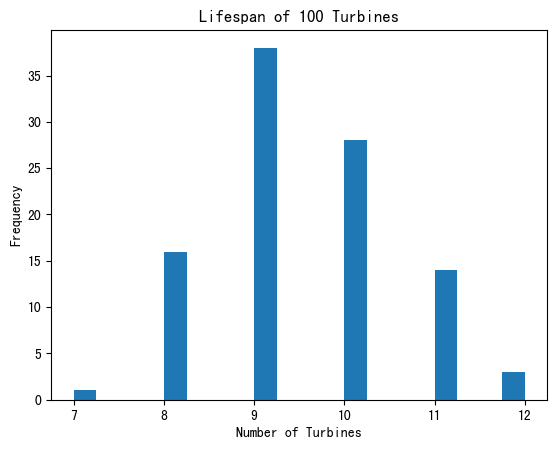

In [6]:
# numberOfTurbines=100
data = np.floor(np.random.normal(loc=10, scale=1, size=numberOfTurbines)).astype('int')

# Plot the histogram of the data
plt.hist(data, bins=20)
plt.xlabel('Number of Turbines')
plt.ylabel('Frequency')
plt.title('Lifespan of 100 Turbines')
plt.show()

In [7]:
# Gearbox Option Valuer

def GearboxVal(cashFlows ,steps , impCostGearbox ):

    ### Section 1 ### ### ### ###
    
    S0 = sum(cashFlows)
    assetLife = len(cashFlows)
    delta = assetLife / steps
    u = np.exp(sigma * np.sqrt(delta)) 
    d = 1/u
    p = ( np.exp(riskFreeRate * delta) - d ) / (u - d)
    tree = np.zeros((steps, steps))


    #Tree Initial Seeding  
    for i in range(0,steps):
        tree[0 , i] = S0 * pow(u,i)  


    #Tree Propagator     
    for i in range(0,steps-1):
        if i < steps-1:
            for j in range(0,steps):
                if j < steps-1:
                    tree[i+1 , j+1] = tree[i,j] * d
    tree[tree == 0] = None

                    
    ### Section 2 ### ### ### ###
        #collapse algorithem , gives us the npv of the gear box replacement
    
    count = 0
    optionTree = np.copy(tree)
    
    for i in range(0,steps):
            gain = ( pow(inflationRate,assetLife+gearBoxLife) - 1 ) / ( pow(inflationRate,assetLife) - 1 )
            case0 = (optionTree[i,steps-1] * gain) - impCostGearbox
            optionTree[i,steps-1] = max(optionTree[i,steps-1] ,case0 )

    for i in range(steps-1, 0 ,-1):
        for j in range(0,steps-1):

            case1 = ( p*optionTree[j , i] + (1-p)*optionTree[j+1 , i] ) * np.exp(-1* riskFreeRate * delta)

            extraYears = max(np.floor(delta*i) + gearBoxLife - assetLife , 0) 
            gain = ( pow(inflationRate,assetLife+extraYears) - 1 ) / ( pow(inflationRate,assetLife) - 1 ) 

            case2 = (optionTree[j , i-1] * gain) - impCostGearbox

            if case2>case1:
                count+=1
                #print("replacement: " + str(count) +" at year: "+ str(np.floor(delta*i)) + " case 2 exceeds by: "+str(case2-case1))
            optionTree[j , i-1] = max(case1 , case2)    
    
    return tree,optionTree

In [8]:
# Testing single failure scenario trees
sigma = SigmaCalculator(cashFlowCalculation,())
tree,optionTree = GearboxVal(TurbineDeathSimulation(scale = 1,loc = 10) ,steps = 31 , impCostGearbox = 200)
#optionTree[0,0] - tree[0,0] # For option value
#pd.DataFrame(tree) # Base tree depending on failure scenario
#pd.DataFrame(optionTree) # Base tree depending on failure scenario , with gearbox replacement option applied


In [9]:
# Below here is for running the american option
#################################################################################

In [10]:
# ######################
# calculates out option values for different failure situations and stores in multiTreeOption array

multiTreeOption = []
steps = 31
locVal = np.arange(1, assetLife-1, (assetLife-2) / steps )

for n in range(0,len(locVal)): 
    
    averageOptionValue=[]
    
    for _ in range(0,50):    
        tree,optionTree = GearboxVal(TurbineDeathSimulation(scale = 1,loc = locVal[n]) ,steps = 31 , impCostGearbox = 200)        
        averageOptionValue.append(optionTree[0,0]-tree[0,0])
         
    multiTreeOption.append( np.mean(averageOptionValue) )
        
multiTreeOption = np.asarray(multiTreeOption)

# ######################
# Estimating mean of standard deviation of logrithmic returns of multiTreeOption

def substitute(multiTreeOption):
    return multiTreeOption
metaSigma = SigmaCalculator(substitute , (multiTreeOption))


print("mean of logrithmic returns standard deviations is: " + str(metaSigma))



# ######################
# Final tree seeding 
    
delta = assetLife / steps 
u = np.exp(metaSigma * np.sqrt(delta)) 
d = 1/u
p = ( np.exp(riskFreeRate * delta) - d ) / (u - d)

finalTree = np.zeros((steps, steps))
finalTree[:,-1] = np.fliplr([multiTreeOption]) # When seeding largest values must be first as that is how BT works


#back propagation algorithem
for i in range(finalTree.shape[1]-1, 0 ,-1):
    for j in range(0,finalTree.shape[1]-1):
        if finalTree[j+1 , i] !=0:
            case1 = ( p*finalTree[j , i] + (1-p)*finalTree[j+1 , i] )           
            finalTree[j , i-1] = case1
            
            
pd.DataFrame(finalTree)

mean of logrithmic returns standard deviations is: 0.06197599467666539


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,344.173803,347.147301,350.098040,353.027242,355.935585,358.823087,361.688989,364.531663,367.348539,370.136056,...,398.834351,400.523161,402.029674,403.334340,404.427134,405.319937,406.064957,406.780909,407.692108,409.195138
1,0.000000,337.744268,340.766977,343.764284,346.738588,349.691999,352.626204,355.542330,358.440790,361.321145,...,392.985778,395.182669,397.265658,399.208622,400.971415,402.496643,403.708994,404.516867,404.810643,404.442137
2,0.000000,0.000000,331.208323,334.285959,337.333006,340.352487,343.347423,346.320724,349.275049,352.212654,...,385.730250,388.235485,390.678664,393.064427,395.396971,397.673443,399.875201,401.962148,403.881641,405.607456
3,0.000000,0.000000,0.000000,324.553612,327.697392,330.804042,333.876595,336.918315,339.932646,342.923123,...,377.606363,380.313230,382.952647,385.519976,388.020814,390.474601,392.912624,395.362637,397.811668,400.149944
4,0.000000,0.000000,0.000000,0.000000,317.755879,320.979943,324.160323,327.299545,330.400487,333.466395,...,368.865473,371.753359,374.606071,377.401362,380.112465,382.715039,385.202911,387.615010,390.067145,392.755660
5,0.000000,0.000000,0.000000,0.000000,0.000000,310.784549,314.103072,317.372445,320.594439,323.771135,...,359.672086,362.621054,365.584996,368.561868,371.539198,374.484971,377.335564,379.987279,382.312806,384.253824
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,303.608973,307.033773,310.405590,313.725531,...,350.384930,353.295591,356.212180,359.148166,362.124047,365.169612,368.321190,371.601813,374.958839,378.115781
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,296.203597,299.742960,303.226947,...,341.170492,344.091266,346.989108,349.863757,352.713477,355.538683,358.355018,361.227563,364.342982,368.132644
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,288.550502,292.209604,...,331.856871,334.854960,337.825319,340.773313,343.701862,346.604591,349.448978,352.143769,354.491155,356.148672
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,280.638498,...,322.270338,325.374164,328.432211,331.450932,334.440969,337.425348,340.454229,343.622086,347.068063,350.907139
